# headmap digitizer
#### PoC prototype for digitizing efficiency map images extracted from pdfs
#### functional demonstration only

## Process

#### Setup overview
1. follow project setup steps in README.md
2. add .png image containing efficiency map and the scale to inputs/images named {ID}.png for example 'YASA_P400.png'
3. set ID parameter under the run section then run all cells below in turn

#### Process overview
1. image is read in and user is prompted to:
- define the boundary of the heatmap and the scale by selecting the lower left and upper right edges in each
- define the min and max x and y coordinates of the heatmap and the scale
- define the region of interest (roi) of the heatmap using the mouse to draw it
2. a scale is defined from the scale image and the min and max coordinates of the scale (both rgb and grayscale versions)
3. optical character recognition (ocr) is used to identify and infill text in the image
4. canny edge detection is used to identify lines, countours etc and infill them in the image
5. grayscale pixels in the roi that are not in the grayscale scale are infilled
6. pixels not in the roi are set to black
7. user is prompted to select regions of the map to infill after processing, for example if the processing has not worked well in certain regions
8. user is promted to select regions of the map to remove after processing, for example if the processing has not worked well and the previous step failed, in certain regions, and these are set to black
9. x, y coordinates are mapped to the image array defined by the min/max x,y values in (1) and the number of pixels on each image axis
10. each pixel is assigned a z value (efficiency in the PoC) based on nearest euclidean distance to a color in the scale (except black, which is oputside the roi) 
11. x,y,z values for the heatmap is output to a dataframe 
12. a heatmap of the dataframe is generated to display the x,y,z values generated by the process
13. the x,y,z lookup is output to /outputs as a csv file

In [283]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import configparser
from PIL import Image, ImageTk
import cv2
import keras_ocr
from scipy.spatial.distance import cdist
import tkinter as tk
from tkinter import simpledialog, messagebox

## get config
- load configuration file and get definitions

In [284]:
def get_config_values():
    """get config value from ini file"""

    config = configparser.ConfigParser()
    config.read('config.ini')
    settings = dict(
        images_path = config['PATHS']['images_path'],
        output_path = config['PATHS']['output_path']
    )

    return settings

## get bounds and scale of efficiency map and scale

- cropper and boundary marker function
- currently this requires user to select bootom left and top right of image to crop
- for the scale, which might be quite thin, this requires a bit of precision
- for the x,y min/max value aquisition, all four values are required or the efficiency map. For the scale on x min/max are required but for now the same class is used and this means the user must input the values twice. It's no hassle, but not perfect UX experience.


In [285]:
def crop_image_with_points(image_path):
    """takes user input to crop both heatmap and scale and input the min/max x/y axis values for each"""
    class ImageCropper:
        def __init__(self, image_path):
            self.image_path = image_path
            self.points = []
            self.bottom_left = None
            self.top_right = None

        # get x and y min and max values from user input into a dict
        def get_values(self):
            value = simpledialog.askstring("Input", "Enter values (x_min, x_max, y_min, y_max) separated by spaces:")
            try:
                x_min, x_max, y_min, y_max = map(int, value.split())
                return {'x_min': x_min, 'x_max': x_max, 'y_min': y_min, 'y_max': y_max}
            except ValueError:
                messagebox.showerror("Error", "Invalid input. Please enter four integer values separated by spaces.")
                return self.get_values()
        
        # get bottom left and top right of image to crop from user input
        def select_points(self, event, x, y, flags, param):
            if event == cv2.EVENT_LBUTTONDOWN:
                if len(self.points) < 2:
                    self.points.append((x, y))
                    cv2.circle(self.image, (x, y), 5, (0, 255, 0), -1) 
                    cv2.imshow('Select Points', self.image) # show the point selected on the image
                    if len(self.points) == 2:
                        self.bottom_left = (min(self.points[0][0], self.points[1][0]), min(self.points[0][1], self.points[1][1]))
                        self.top_right = (max(self.points[0][0], self.points[1][0]), max(self.points[0][1], self.points[1][1]))
        # crop image based on values from select_points
        def crop_image(self):
            if len(self.points) == 2:
                cropped_image = self.image[self.bottom_left[1]:self.top_right[1], self.bottom_left[0]:self.top_right[0]]
                cv2.imshow('Cropped Image', cropped_image) # show cropped image
                return cropped_image
            else:
                messagebox.showerror("Error", "Please select 2 points.")
                return None

        def run(self):
            self.image = cv2.imread(self.image_path)

            # initially show image and instruct user to select points to crop image
            cv2.namedWindow('Select Points', cv2.WINDOW_NORMAL)
            cv2.setWindowProperty('Select Points', cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN) # full screen auto-detect
            cv2.imshow('Select Points', self.image) 
            messagebox.showinfo("Instruction", "Please select the bottom left and top right corners of the cropping rectangle using the mouse pointer then press Enter.")
            cv2.setMouseCallback('Select Points', self.select_points) #pass selected points from mouse click to select_points

            while True:
                key = cv2.waitKey(1) & 0xFF
                if key == ord('\r'): # exit cropping session on enter
                    cropped_image = self.crop_image()
                    if cropped_image is not None:
                        return cropped_image, self.get_values()
                elif key == ord('q'): # exit session on enter 'q'
                    break

            cv2.destroyAllWindows() 
            return None, None

    # create an ImageCropper instance
    cropper = ImageCropper(image_path) # instantiate the cropper class

    # get cropped image and boundary values from cropper class instance run method
    cropped_image, values = cropper.run() 

    cv2.destroyAllWindows() # get rid of the image display windows

    return cropped_image, values

In [286]:
def get_efficiency_map_bounds(ID, settings):
    """crop efficiency map image and get boundary dict from user input"""
    
    image_path = os.path.join(settings['images_path'], ID +'.png')
    em_img, em_boundaries_dict = crop_image_with_points(image_path)

    return em_img, em_boundaries_dict

In [287]:
def get_scale_bounds(ID, settings):
    """crop scale image and get boundary dict from user input"""
    
    image_path = os.path.join(settings['images_path'], ID +'.png')
    sc_img, sc_boundaries_dict = crop_image_with_points(image_path)

    return sc_img, sc_boundaries_dict

## define ROI
- user marks region of interest (ROI) for the heatmap data
- region outside of this is set to black

In [288]:
def define_roi(im):
    """define a region of interest (roi) for the heatmap based on user input from a mouse drawing pointer"""
    drawing = False  
    points = []  

    # get x, y coords for each mouse event
    def draw_boundary(event, x, y, flags, param):
        nonlocal drawing, points

        # get coords for mouse left buttom down
        if event == cv2.EVENT_LBUTTONDOWN:
            drawing = True
            points = [(x, y)]

        # get coords for mouse move
        elif event == cv2.EVENT_MOUSEMOVE:
            if drawing:
                points.append((x, y))

        # get coords for mouse left buttom release and set drawing to false for callback
        elif event == cv2.EVENT_LBUTTONUP:
            drawing = False
            points.append((x, y))

    #image = cv2.imread(os.path.join('inputs\efficiency_maps', ID +'.png'))
    image = im
    result = image.copy()  # create a copy of the image for drawing purposes
    cv2.namedWindow('Define roi', cv2.WINDOW_NORMAL)
    cv2.setWindowProperty('Define roi', cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN) # full screen auto-detect
    cv2.setMouseCallback('Define roi', draw_boundary) # mouse call back for draw_boundary

    messagebox.showinfo("Instruction", "Please draw the region of interest of the efficiency map using the mouse pointer then press 'Enter'. If you want to reset at any time press 'r'. If you do not want to select and region just press 'Enter'")

    while True:
        for i in range(1, len(points)):
            cv2.line(result, points[i - 1], points[i], (0, 0, 255), 2)
        cv2.imshow('Define roi', result) # show drawn region while one exists

        key = cv2.waitKey(1) & 0xFF

        # reset the image if 'r' is pressed
        if key == ord('r'):
            result = image.copy()
            points = []

        # finish capture if Enter is pressed
        elif key == ord('\r'):
            break

    # create and return the roi mask 
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    if points:
        cv2.fillPoly(mask, [np.array(points)], (255, 255, 255))
    
    cv2.destroyAllWindows() # clear the display of the images

    return mask

## get scale
- scale a one pixel width copy of the scale image by the range of efficiencies
- if rgb's span multiple efficiencies (assumtpion they will no be separated by much) then take the mean efficiency over the rgb's
- get distinct grayscale value of the scale

In [289]:
def get_scale(im, sc_boundaries_dict):
    # get image, create grayscale version and array 
    scale_image = im
    gs_scale_image = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    grayscale_array = np.array(gs_scale_image)

    # distinct grayscale values
    array = np.array([x[0] for x in grayscale_array])
    seen = set()
    grayscale = []
    for i in array:
        if i not in seen:
            seen.add(i)
            grayscale.append(i)

    # rgb array
    scale = np.array(scale_image)
    scale = scale[:,0,:3] # make this scale 1D

    # define range of the scale
    su = sc_boundaries_dict['x_max']
    sl = sc_boundaries_dict['x_min']
    scale_range = su - sl

    # determine fidelity from number of pixels
    scale_items = scale.shape[0]
    scale_fidelity = scale_range / scale_items

    # map scale to colours in scale image
    z_values = (np.arange(1, scale_items + 1) * scale_fidelity) + sl
    z_values = z_values[::-1] # invert as is from large to small in scale
    z_values_df = pd.DataFrame(z_values, columns=['z'])
    scale_df = pd.DataFrame(scale, columns=['r', 'g', 'b'])
    scale_df = scale_df.join(z_values_df)
    
    # if rgb occurs > once in the scale take the mean of the scale value assigned
    scale_df = (scale_df.groupby(['r','g','b']).agg(z_mean=('z', 'mean'))).reset_index()
    scale = scale_df.values.astype(np.uint8)

    return scale, grayscale

## get efficiency map

#### infill text
- read cropped efficiency map image 
- use a bounding box ocr to identify text
- inpaint these regions

In [290]:
def infill_text(img):
    """infill text using ocr"""

    # return mid-point tuple for x and y
    def midpoint(x1, y1, x2, y2):
        x_mid = int((x1 + x2)/2)
        y_mid = int((y1 + y2)/2)
        return (x_mid, y_mid)

    # download pre-trained ocr model
    pipeline = keras_ocr.pipeline.Pipeline()

    #img = keras_ocr.tools.read(os.path.join('inputs\efficiency_maps', ID +'.png'))

    # get tuple of words and boxes for text recognized
    prediction_groups = pipeline.recognize([img])

    #create a mask based on the midpoints of the boxes x,y coordinates and infill
    mask = np.zeros(img.shape[:2], dtype="uint8")
    for box in prediction_groups[0]:
        x0, y0 = box[1][0]
        x1, y1 = box[1][1] 
        x2, y2 = box[1][2]
        x3, y3 = box[1][3] 
        
        x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
        x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)
        
        thickness = int(math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))
        
        cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255,    
        thickness)
        img = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)
                    
    return(img)

In [291]:
def gaussian_blur(im):
    """apply gaussian blue with 5x5 kernel"""

    blurred = cv2.GaussianBlur(im, (5, 5), 0)

    return blurred

#### infill lines and egdes
- convert image output to grayscale
- Use Canny edge detection to identify edges
- inpaint these extended by a region

In [292]:
def infill_lines(im):
    """infill lines and curves"""

    # convert to grayscale
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    # use canny edge detection to identify edges
    edges = cv2.Canny(gray, 50, 150)

    # create a mask by dilating the edges and infill
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.dilate(edges, kernel, iterations=1)

    nolines = cv2.inpaint(im, mask, inpaintRadius=3, flags=cv2.INPAINT_NS)

    return nolines

#### infill not in scale
- infill regions where the pixel values are not in the scale (or white)

In [293]:
def infill_not_in_scale(im, grayscale):

    # convert to grayscale
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    # define a set of grayscales in the scale + white
    _white = [255] # white grayscale, as we don't want to infill the background to most images which are white
    in_grayscale = grayscale + _white

    # infill image where the pixels are not in the grayscale defined by the scale
    mask = np.ones_like(gray) * 255  
    for value in in_grayscale:
        mask[gray == value] = 0

    inscale = cv2.inpaint(im, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    return inscale

#### apply the roi
- make region outside the roi black so it gets a zero z value

In [294]:
def apply_roi(im, mask_roi):
    """set region outside roi to black"""
    im[mask_roi == 0] = [0, 0, 0]

    return im

## infill regions
- enable user to select regions to infill manually where automated infilling has not worked

In [295]:
def inpaint_regions(image):
    """User function to paint areas of heatmap to infill"""
    def draw_circle(event, x, y, flags, param):
        nonlocal drawing, mode, img

        if event == cv2.EVENT_LBUTTONDOWN:
            drawing = True
            ix, iy = x, y

        elif event == cv2.EVENT_MOUSEMOVE:
            if drawing:
                if mode:
                    cv2.circle(img, (x, y), 3, (255, 255, 255), -1)
                else:
                    cv2.circle(img, (x, y), 3, (0, 0, 0), -1)

        elif event == cv2.EVENT_LBUTTONUP:
            drawing = False
            if mode:
                cv2.circle(img, (x, y), 3, (255, 255, 255), -1)
            else:
                cv2.circle(img, (x, y), 3, (0, 0, 0), -1)

    def inpaint_image(image, mask):
        return cv2.inpaint(image, mask, 3, cv2.INPAINT_TELEA)

    img = np.copy(image)
    drawing = False  
    mode = True  

    messagebox.showinfo("Instruction", "Please paint areas to remove then press 'Enter'. If you do not want to remove anything just press 'Enter'. Press 'm' to enter erase mode and again to go back if you need to erase anything.")

    cv2.namedWindow('Inpaint', cv2.WINDOW_NORMAL)
    cv2.setWindowProperty('Inpaint', cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN) # full screen auto-detect
    cv2.setMouseCallback('Inpaint', draw_circle)

    while True:
        cv2.imshow('Inpaint', img)
        key = cv2.waitKey(1) & 0xFF

        if key == ord('m'):
            mode = not mode
        elif key == ord('\r'):
            mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
            mask[img[:, :, 0] == 255] = 255
            img = inpaint_image(img, mask)
            break

    cv2.destroyAllWindows()
    return img

## paint regions
- enable user to paint regions black to exclude from heatmap data
- this will ensure z value is zero where infilling has not worked

In [296]:
def paint_regions(image):
    """User function to paint areas of heatmap to remove"""
    drawing = False

    messagebox.showinfo("Instruction", "Please paint areas to remove then press'Enter'. If you do not want to select and region just press 'Enter'")

    cv2.namedWindow('Paint', cv2.WINDOW_NORMAL)
    cv2.setWindowProperty('Paint', cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN) # full screen auto-detect
    cv2.setMouseCallback('Paint', lambda event, x, y, flags, param: paint_callback(event, x, y, image, drawing))

    while True:
        cv2.imshow('Paint', image)
        key = cv2.waitKey(1) & 0xFF

        # Exit is 'Enter' is pressed
        if key == ord('\r'):
            break

    cv2.destroyAllWindows()
    return image

def paint_callback(event, x, y, image, drawing):
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        cv2.circle(image, (x, y), 2, (0, 0, 0), -1)

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            cv2.circle(image, (x, y), 2, (0, 0, 0), -1)

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False

## make efficiency lookup
- map the efficiency map image dimensions to the speed/torque dimensions from metadata
- map rbg's to efficiencies from the scale data
- produce speed, torque, efficiency mapping for pixels that are in the scale and output to csv

In [297]:
def efficiency_lookup(im, scale, em_boundaries_dict):
    # git heatmap boundaries from boundaries dict
    x_rl = em_boundaries_dict['x_max']
    x_ll = em_boundaries_dict['x_min']
    max_xi = im.shape[1] - 1 # image arrays are expressed as y,x pair in opencv not x,y, so dimension 1 represents x

    y_lu = em_boundaries_dict['y_max']
    y_ll = em_boundaries_dict['y_min']
    max_yi = im.shape[0] - 1

    x = []
    y = []
    z = []

    # get z value from scale of nearest neighbour colour for a pixel
    def find_closest_rgb(pixel, scale):
        if not np.all(pixel == [0, 0, 0]):
            distances = cdist([pixel], scale[:,:3])
            closest_index = np.argmin(distances)
            zval = scale[closest_index][3]
        else:
            zval = 0
        return zval
    
    # map image coordinates to axis coordinates and get zvalue for each pixel
    for xi in range(im.shape[1]):
        for yi in range(im.shape[0]):
            xbar = ((x_rl - x_ll) * xi) / max_xi
            ybar = ((y_lu - y_ll) * (max_yi - yi)) / max_yi # the additional - yi in second factor is because y axis is 'upside down'
            zi = find_closest_rgb(im[yi, xi], scale)
            x.append(xbar)
            y.append(ybar)
            z.append(zi)

    efficiency_lookup_df = pd.DataFrame(zip(x,y,z),columns=(['speed','torque','efficiency']))

    return efficiency_lookup_df

## display the processed efficiency map lookup as a heatmap

In [298]:
def efficiency_heatmap(efficiency_lookup_df, sc_boundaries_dict):
    """display heatmap generated from output data from image processing process"""
    
    heatmap_data = efficiency_lookup_df.pivot_table(index='torque', columns='speed', values='efficiency')
    heatmap_data = heatmap_data.iloc[::-1]

    vmin = sc_boundaries_dict['x_min']
    vmax = sc_boundaries_dict['x_max']

    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, cmap='viridis', vmin=vmin, vmax=vmax)
    plt.title('Efficiency Heatmap')
    plt.xlabel('Speed')
    plt.ylabel('Torque')
    plt.show()

## write efficiency map lookup to csv

In [299]:
def output_efficienct_map_lookup(ID, df, settings):
    df.to_csv('outputs\efficiency_map_lookup_'+ ID +'.csv')
    os.path.join(settings['output_path'], ID +'.png')

## run all methods

In [300]:
def process(ID):
    settings = get_config_values()
    em_img, em_boundaries_dict = get_efficiency_map_bounds(ID, settings)
    plt.imshow(em_img)
    sc_img, sc_boundaries_dict = get_scale_bounds(ID, settings)
    mask_roi = define_roi(em_img)
    scale, grayscale = get_scale(sc_img, sc_boundaries_dict)
    em = infill_text(em_img)
    nolines = infill_lines(em)
    inscale = infill_not_in_scale(nolines, grayscale)
    roi = apply_roi(inscale, mask_roi)
    inpaint = inpaint_regions(roi)
    paint = paint_regions(inpaint)
    efficiency_lookup_df = efficiency_lookup(paint, scale, em_boundaries_dict)
    efficiency_heatmap(efficiency_lookup_df, sc_boundaries_dict)
    output_efficienct_map_lookup(ID, efficiency_lookup_df, settings)

## main

In [301]:
ID = 'HDSRM300'
#ID = 'YASA_P400'
#ID = '180-100-009'
#ID = 'URBAN'
#ID = 'CITATION'

Looking for C:\Users\benst\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\benst\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 2s 2s/step


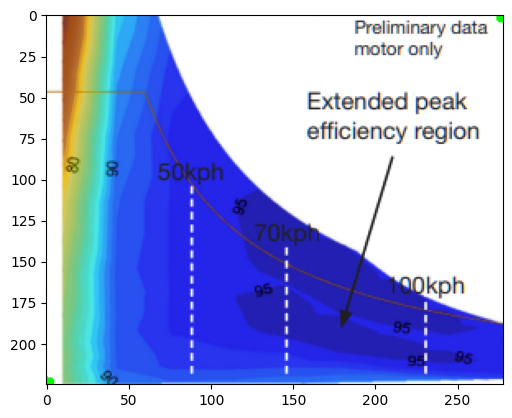

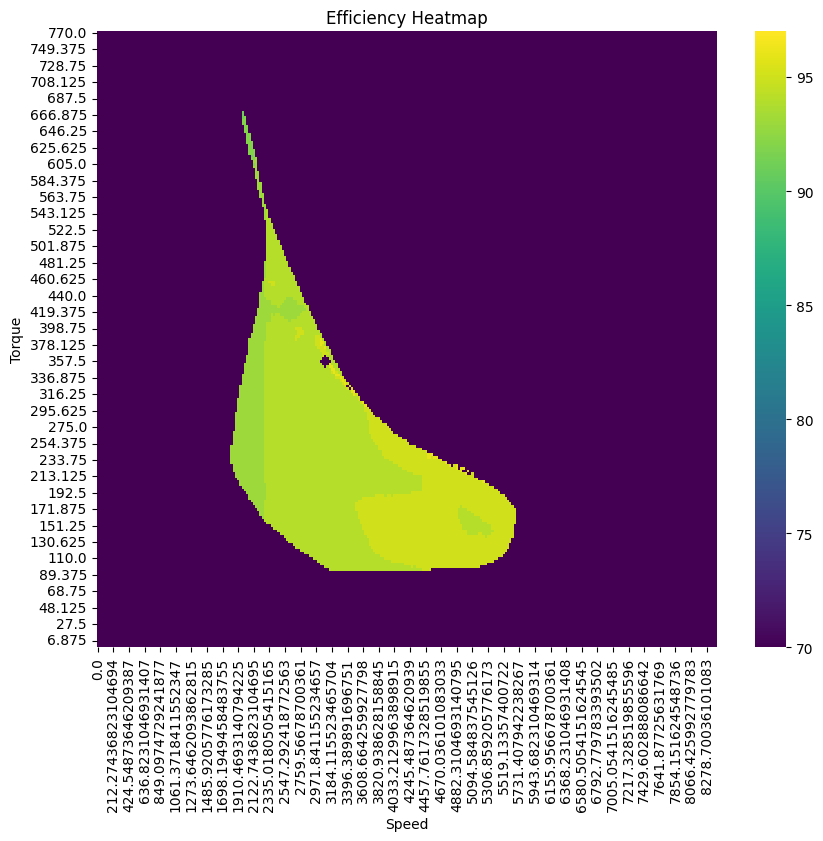

In [302]:
process(ID)

In [136]:
#settings = get_config_values()
#em_img, em_boundaries_dict = get_efficiency_map_bounds(ID, settings)
#plt.imshow(em_img)
#sc_img, sc_boundaries_dict = get_scale_bounds(ID, settings)
#mask_roi = define_roi(em_img)
#scale, grayscale = get_scale(sc_img, sc_boundaries_dict)
#em = infill_text(em_img)
#plt.show()
#plt.imshow(em)
#nolines = infill_lines(em)
#plt.show()
#plt.imshow(nolines)
#inscale = infill_not_in_scale(nolines, grayscale)
#plt.show()
#plt.imshow(inscale)
#roi = apply_roi(inscale, mask_roi)
#plt.show()
#plt.imshow(roi)
#inpaint = inpaint_regions(roi)
#plt.show()
#plt.imshow(inpaint)
#paint = paint_regions(inpaint)
#plt.show()
#plt.imshow(roi)
#efficiency_lookup_df = efficiency_lookup(paint, scale, em_boundaries_dict)
#efficiency_heatmap(efficiency_lookup_df, sc_boundaries_dict)
#output_efficienct_map_lookup(ID, efficiency_lookup_df, settings)

Looking for C:\Users\benst\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\benst\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 3s 3s/step


In [51]:
#TODO assumes vertical scale bar (add option to rotate)
#TODO cropper class shared amoungst efficiency map and scale use cases could have differing functionality for each
#TODO rewrite to remove for loops, add vectorisation
#TODO consider dynamic naming of axis throughout, no reason why it has to be speed, torque etc
#TODO user input stages could be improved to perhaps show a screenshot of what to do
#TODO user inputs for axis have to be integer - change this to float

# For second phase
#TODO code as .py
#TODO docstrings for functions
#TODO pyreqs for more parsimonious requirements.txt
#TODO certain functions and classes to utils folder
#TODO modularise so functions do one job only, currently function are broadly packages of work that define process stages
#TODO better nomenclature throughtout i.e. objects given more extensible and meaninful names, not given names and kept generic (i.e. df, dict, img) if within functions etc